In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.1


In [0]:
!git clone https://github.com/gotsulyak8/track1

fatal: destination path 'track1' already exists and is not an empty directory.


In [0]:
!ls track1

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [0]:
datadir = 'track1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  /home/gotsul/Desktop/Data/IMG/center_2020_02_04_21_48_42_507.jpg  ...  0.000079
1  /home/gotsul/Desktop/Data/IMG/center_2020_02_04_21_48_42_610.jpg  ...  0.000078
2  /home/gotsul/Desktop/Data/IMG/center_2020_02_04_21_48_42_718.jpg  ...  0.000078
3  /home/gotsul/Desktop/Data/IMG/center_2020_02_04_21_48_42_822.jpg  ...  0.000080
4  /home/gotsul/Desktop/Data/IMG/center_2020_02_04_21_48_42_927.jpg  ...  0.000080

[5 rows x 7 columns]

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

center  ...     speed
0  center_2020_02_04_21_48_42_507.jpg  ...  0.000079
1  center_2020_02_04_21_48_42_610.jpg  ...  0.000078
2  center_2020_02_04_21_48_42_718.jpg  ...  0.000078
3  center_2020_02_04_21_48_42_822.jpg  ...  0.000080
4  center_2020_02_04_21_48_42_927.jpg  ...  0.000080

[5 rows x 7 columns]

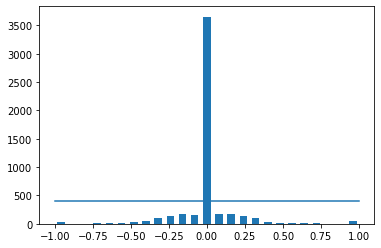

In [0]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5 # *0.5 for restore appropriate range
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5037
removed: 3255
remaining: 1782


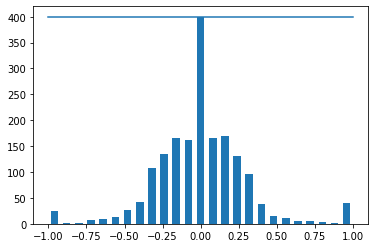

In [0]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i) 
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_) 

print('removed:', len(remove_list))   
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print(data.iloc[0])

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering) 
  return image_path, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_02_04_21_48_45_769.jpg
left        left_2020_02_04_21_48_45_769.jpg  
right       right_2020_02_04_21_48_45_769.jpg 
steering   -0.326112                          
throttle    1                                 
reverse     0                                 
speed       3.53953                           
Name: 31, dtype: object


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=8)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1425
Valid Samples: 357


Text(0.5, 1.0, 'Validation set')

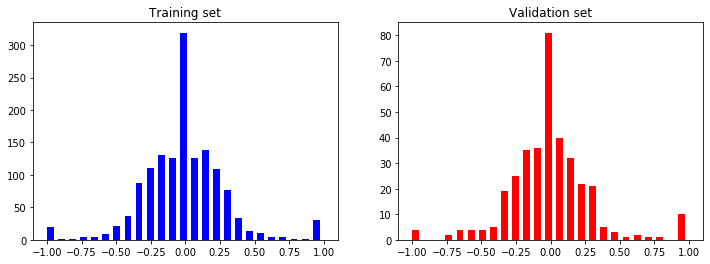

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed Image')

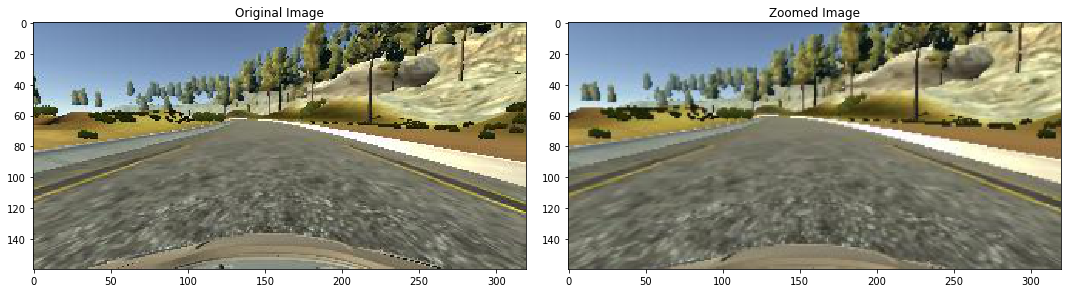

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1, 'Panned Image')

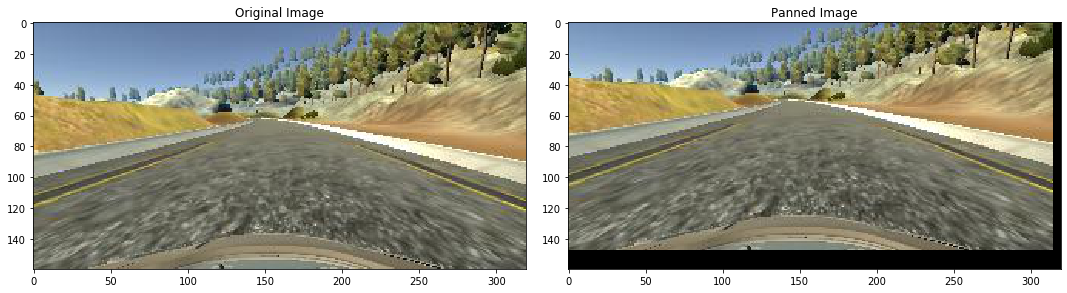

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1, 'Brightness altered Image')

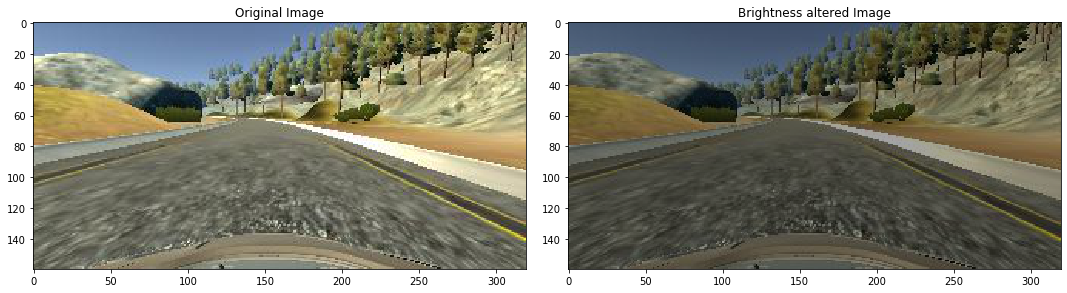

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered Image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1, 'Flipped Image - Steering Angle:0.3261116')

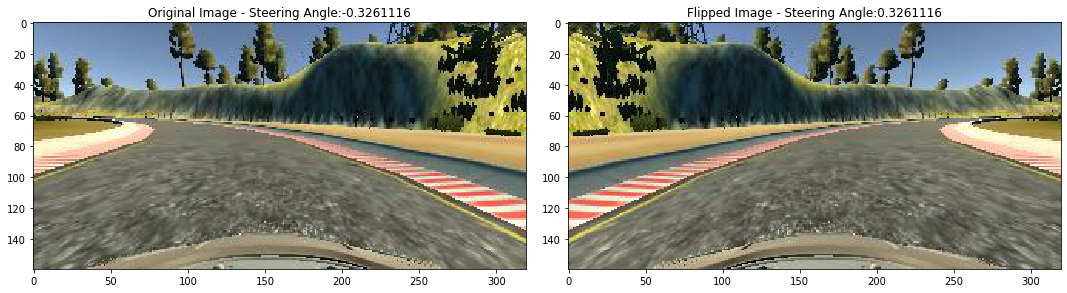

In [0]:
random_index = random.randint(0, 1)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - '+ 'Steering Angle:'+str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - '+ 'Steering Angle:'+str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image) 
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)  
 
  return image, steering_angle   

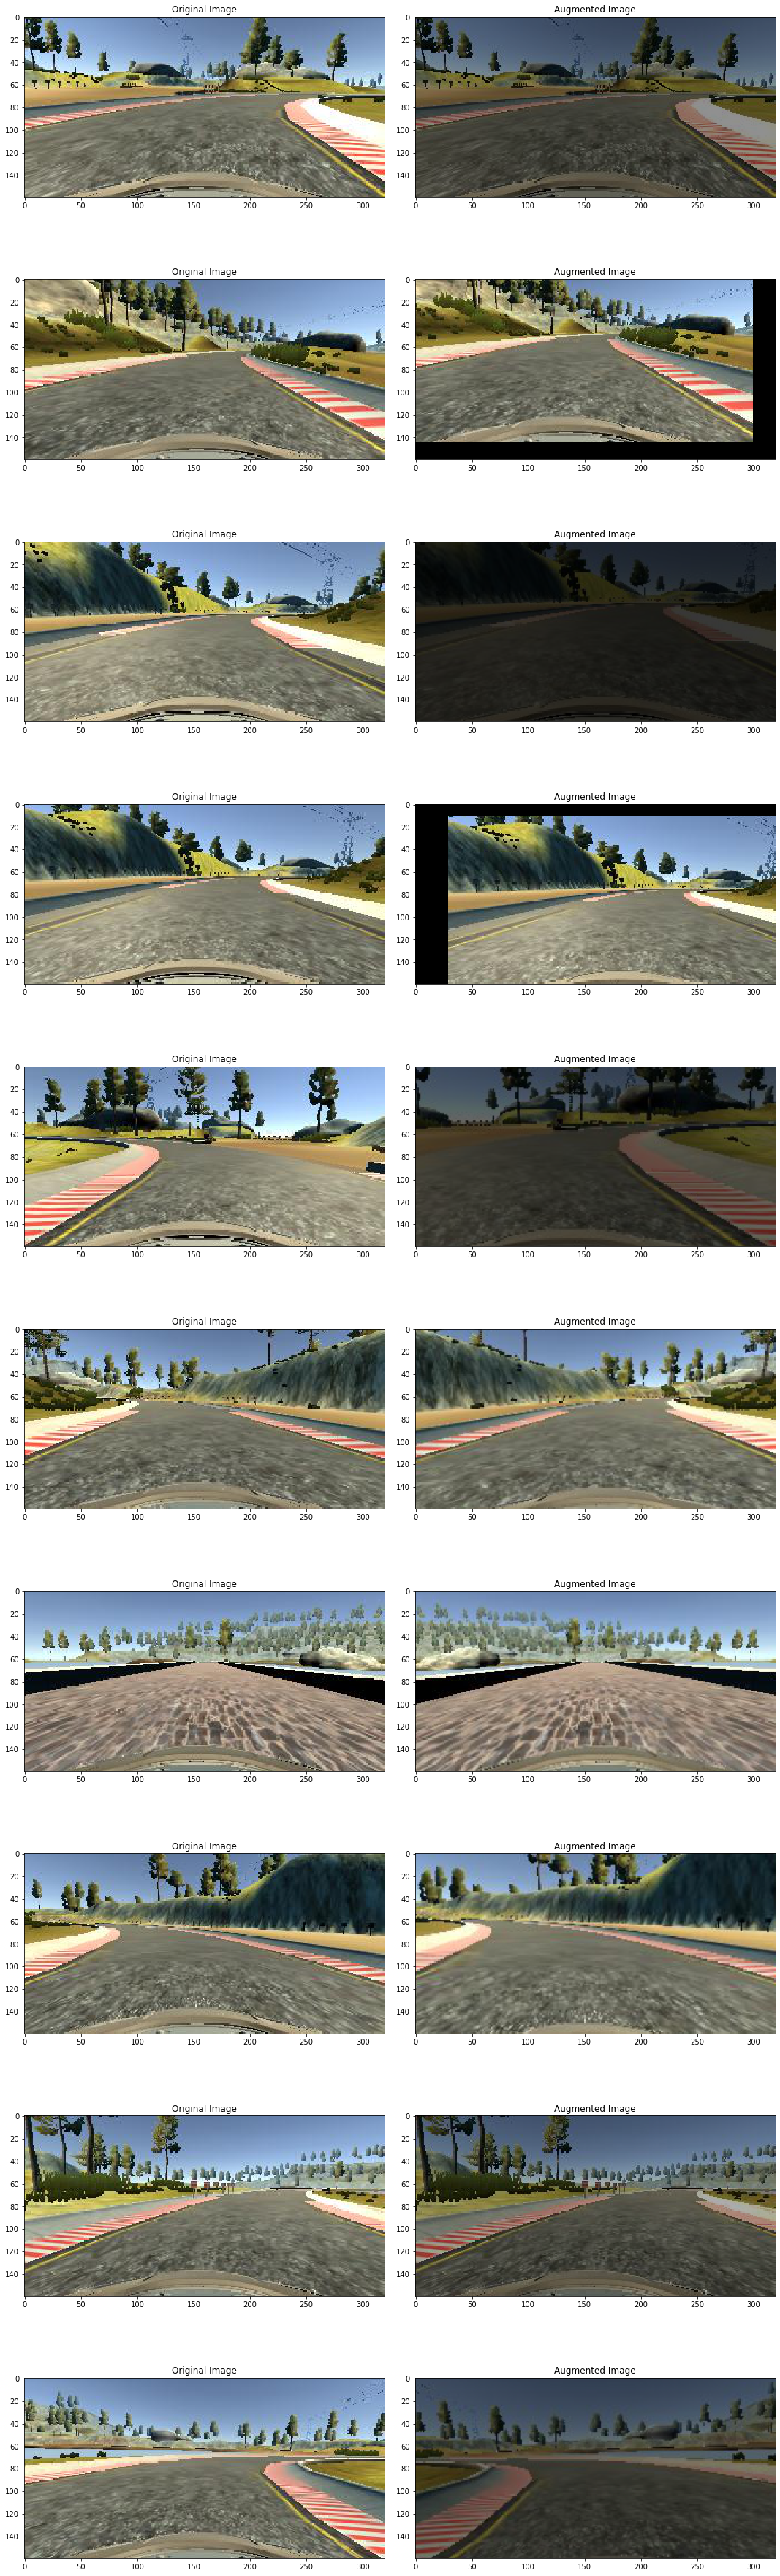

In [0]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
  img = img[60:135, :,: ] # cut unnecessary features
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Change RGB to YUV
  img = cv2.GaussianBlur(img, (3, 3), 0) # Make image more smooth (less noise)
  img = cv2.resize(img, (200, 66))
  img = img/255 # normalization
  return img

Text(0.5, 1, 'Preprocessed Image')

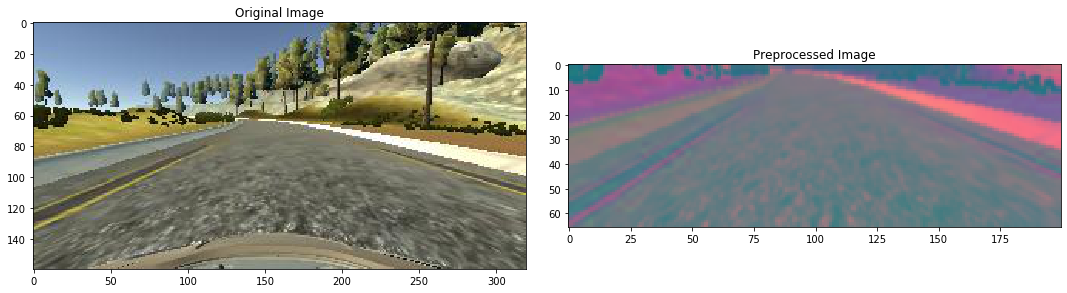

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index]) 
        steering = steering_ang[random_index] 

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1, 'Validation Image')

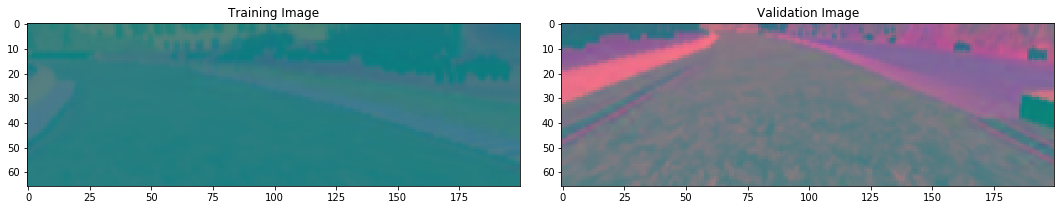

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))

  model.add(Conv2D(64, (3, 3), activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [0]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)                         

Epoch 1/10
300/300 [==============================] - 435s 1s/step - loss: 0.0833 - val_loss: 0.0723
Epoch 2/10
300/300 [==============================] - 431s 1s/step - loss: 0.0710 - val_loss: 0.0601
Epoch 3/10
300/300 [==============================] - 435s 1s/step - loss: 0.0662 - val_loss: 0.0505
Epoch 4/10
300/300 [==============================] - 438s 1s/step - loss: 0.0590 - val_loss: 0.0416
Epoch 5/10
300/300 [==============================] - 440s 1s/step - loss: 0.0528 - val_loss: 0.0372
Epoch 6/10
300/300 [==============================] - 438s 1s/step - loss: 0.0504 - val_loss: 0.0442
Epoch 7/10
300/300 [==============================] - 430s 1s/step - loss: 0.0471 - val_loss: 0.0368
Epoch 8/10
300/300 [==============================] - 426s 1s/step - loss: 0.0465 - val_loss: 0.0376
Epoch 9/10
300/300 [==============================] - 409s 1s/step - loss: 0.0442 - val_loss: 0.0340
Epoch 10/10
300/300 [==============================] - 421s 1s/step - loss: 0.0428 - val_lo

Text(0.5, 0, 'epoch')

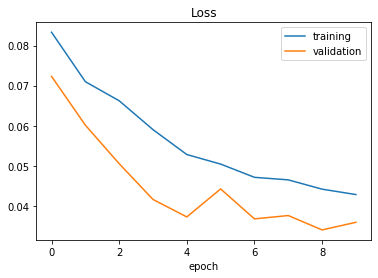

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')